In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

np.random.seed(2026)

logger = get_logger()

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Input files

signal = 'signal_add.0.npz'

bkgnd = 'bkgnd_add.0.npz'

In [4]:
# Load input files

def load_signal(f):
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  with np.load(f) as loaded:
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_hits_bkgnd: {0}'.format(out_hits.shape))
  return (out_hits,)

In [5]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
bkghits_arrays, = load_bkgnd(bkgnd)

[INFO    ] out_part: (2115216, 10) out_hits: (2115216, None, 8) out_simhits: (2115216, None, 8)
[INFO    ] out_hits_bkgnd: (16289880, None, 8)


In [6]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358    0.39852655   1.           0.        ] [[   0    0  267 4267   14   12    0   -1]
 [   0    3  275 4404    0   18    0    0]
 [   0    4  276 4413    2   18    0   -1]
 [   0    5  277 4431    1   18    0    1]
 [   0    6  277 4433    0   19    0    1]
 [   0    7  278 4440    0   19   19    1]
 [   0    8  278 4446    0   19    0    0]] [[   0    0  267 4264    0   13    0    0]
 [   0    2  270 4324    0   14    0    0]
 [   0    3  275 4404    0   17    0    0]
 [   0    4  276 4413    0   18    0    0]
 [   0    5  277 4428    0   18    0    0]
 [   0    6  277 4434    0   19    0    0]
 [   0    7  278 4440    0   19    0    0]
 [   0    8  278 4445    0   19    0    0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 2.6855508e-02 0.0000000e+00 2.0000000e+00] [[   2    2  151 2408    0   88    0   -1]
 [   2    4  155 2476    3   85    0 

In [7]:
zone = 0

num = 20000

# Image format
num_channels = 1 + 2
num_cols, col_offset = 300, 20  # truncate the first 20 unit
num_rows = 10
num_pars = 5
assert((max_emtf_strip//coarse_emtf_strip) == num_cols + col_offset)

# Particle binning
invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49277655, -0.24515343, -0.06501561, 0.06501561, 0.24515343, 0.49277655])
  dzero_bins = np.array([-149.01635796, -80.24550629, -19.69444885, 19.69444885, 80.24550629, 149.01635796])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49370697, -0.26011642, -0.07240327, 0.07240327, 0.26011642, 0.49370697])
  dzero_bins = np.array([-148.42751366, -75.90176582, -18.08490837, 18.08490837, 75.90176582, 148.42751366])
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

In [8]:
def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)
  return ind

def find_par_row_col(par):
  (invpt, d0, eta, phi, invpt2) = par
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

In [9]:
# Build images

class Particle(object):
  def __init__(self, part_array):
    self.invpt = part_array[0]
    self.eta = part_array[1]
    self.phi = part_array[2]
    self.vx = part_array[3]
    self.vy = part_array[4]
    self.vz = part_array[5]
    self.d0 = part_array[6]
    self.phi_s = part_array[7]
    self.sector = part_array[8]
    self.zone = part_array[9]

  def get_parameters(self):
    return (self.invpt, self.d0, self.eta, self.phi, self.invpt)

class Hit(object):
  def __init__(self, hit_array):
    self.zone = hit_array[0]
    self.zone_row = hit_array[1]
    self.zone_col = hit_array[2]
    self.emtf_phi = hit_array[3]
    self.emtf_bend = hit_array[4]
    self.emtf_theta = hit_array[5]
    self.emtf_theta_alt = hit_array[6]
    self.emtf_qual = hit_array[7]

  def get_channels(self):
    ch0 = 1.0  # valid flag
    ch1 = (1.0 * np.true_divide(self.emtf_phi, coarse_emtf_strip)) - (1.0 * self.zone_col)
    ch2 = 1.0 * self.emtf_bend
    return (ch0, ch1, ch2)

def build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=-1):
  _capacity = 600000  #FIXME
  images = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.float32)
  images_gt = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.float32)
  params = np.zeros((_capacity, num_pars), dtype=np.float32)
  print('Successfully reserved huge arrays.')

  zipped = zip(part_arrays, hits_arrays, simhits_arrays, bkghits_arrays)
  i = 0

  for (part_array, hits_array, simhits_array, bkghits_array) in zipped:
    if i == _capacity or i == num:
      break

    part = Particle(part_array)
    if (int(part.zone) != zone):
      continue

    found_pref_row = False  #FIXME
    for simhit_array in simhits_array:
      simhit = Hit(simhit_array)
      if (int(simhit.zone) == zone) and (int(simhit.zone_row) == pref_row):
        found_pref_row = True
    if not found_pref_row:
      continue

    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    # Fill images
    for hit_array in hits_array:
      hit = Hit(hit_array)
      if hit.zone != zone:
        continue
      assert(hit.zone_col >= 0)
      images[i, hit.zone_row, (hit.zone_col - col_offset)] = hit.get_channels()

    # Fill images_gt
    for simhit_array in simhits_array:
      simhit = Hit(simhit_array)
      if simhit.zone != zone:
        continue
      assert(simhit.zone_col >= 0)
      images_gt[i, simhit.zone_row, (simhit.zone_col - col_offset)] = simhit.get_channels()

    # Fill params
    params[i] = part.get_parameters()
    i += 1

  # Resize
  images.resize((i, num_rows, num_cols, num_channels))
  images_gt.resize((i, num_rows, num_cols, num_channels))
  params.resize((i, num_pars))
  return (images, images_gt, params)

In [10]:
images, images_gt, params = build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=num)

print(len(images), len(images_gt), len(params))
print(images[0].shape, images_gt[0].shape, params[0].shape)

Successfully reserved huge arrays.
Building image 0
Building image 10000
20000 20000 20000
(10, 300, 3) (10, 300, 3) (5,)


In [11]:
# Debug
print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

[[ 1.     -0.3125 14.    ]
 [ 1.      0.25    0.    ]
 [ 1.     -0.1875  2.    ]
 [ 1.     -0.0625  1.    ]
 [ 1.      0.0625  0.    ]
 [ 1.     -0.5     0.    ]
 [ 1.     -0.125   0.    ]]
[[ 1.     -0.1875  0.    ]
 [ 1.     -0.25    9.    ]
 [ 1.      0.4375  4.    ]
 [ 1.     -0.5     5.    ]
 [ 1.     -0.375   0.    ]
 [ 1.      0.125   1.    ]
 [ 1.      0.0625  0.    ]]
[[ 1.     -0.375  -7.    ]
 [ 1.      0.0625 -8.    ]
 [ 1.     -0.5    -8.    ]]
[[  1.       0.4375 -20.    ]
 [  1.      -0.3125  -5.    ]
 [  1.      -0.375    0.    ]
 [  1.      -0.5      0.    ]
 [  1.       0.       0.    ]
 [  1.      -0.1875   0.    ]
 [  1.       0.3125   0.    ]]


In [12]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

In [13]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


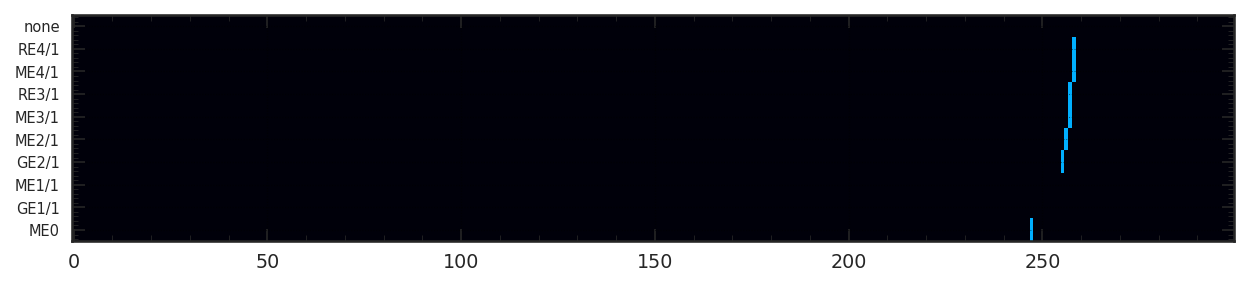

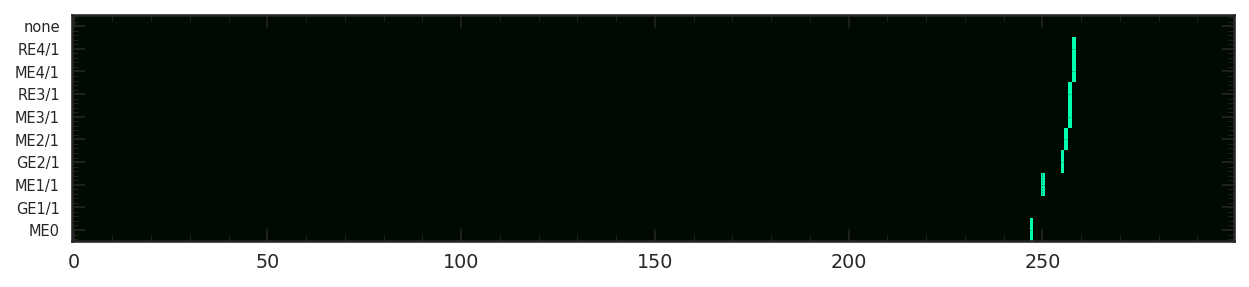

(array([0, 3, 4, 5, 6, 7, 8]), array([247, 255, 256, 257, 257, 258, 258]))
(array([0, 2, 3, 4, 5, 6, 7, 8]), array([247, 250, 255, 256, 257, 257, 258, 258]))


In [14]:
display_image(zone, images[0])
display_image(zone, images_gt[0], cmap=green_hot)

print(np.nonzero(images[0][...,0]))
print(np.nonzero(images_gt[0][...,0]))

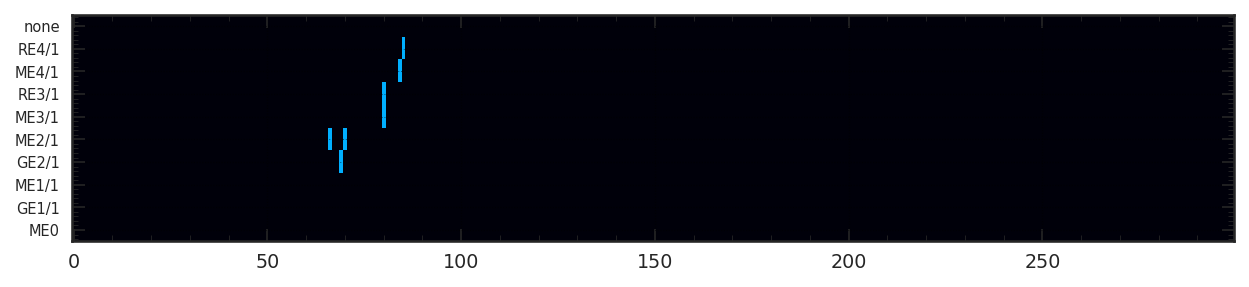

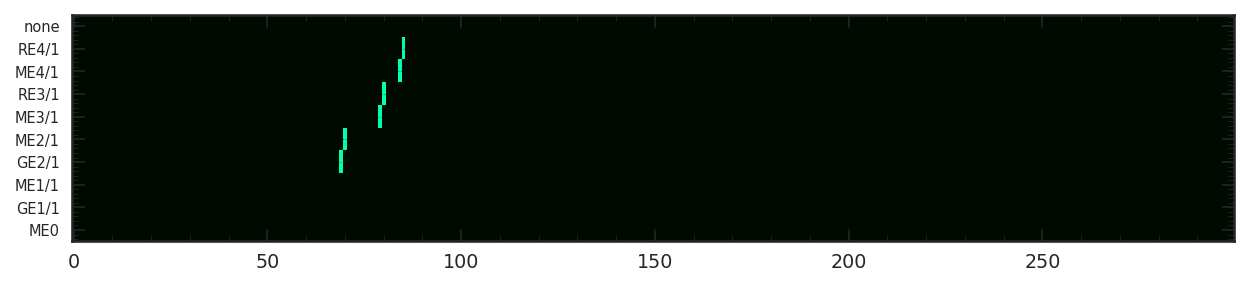

(array([3, 4, 4, 5, 6, 7, 8]), array([69, 66, 70, 80, 80, 84, 85]))
(array([3, 4, 5, 6, 7, 8]), array([69, 70, 79, 80, 84, 85]))


In [15]:
display_image(zone, images[1])
display_image(zone, images_gt[1], cmap=green_hot)

print(np.nonzero(images[1][...,0]))
print(np.nonzero(images_gt[1][...,0]))

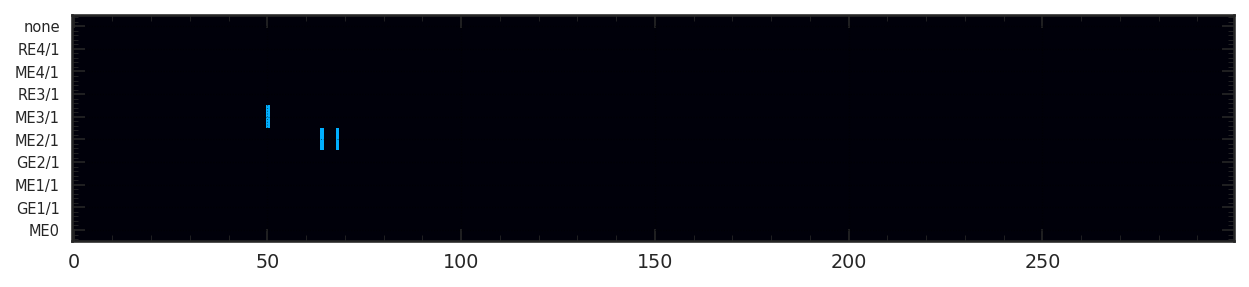

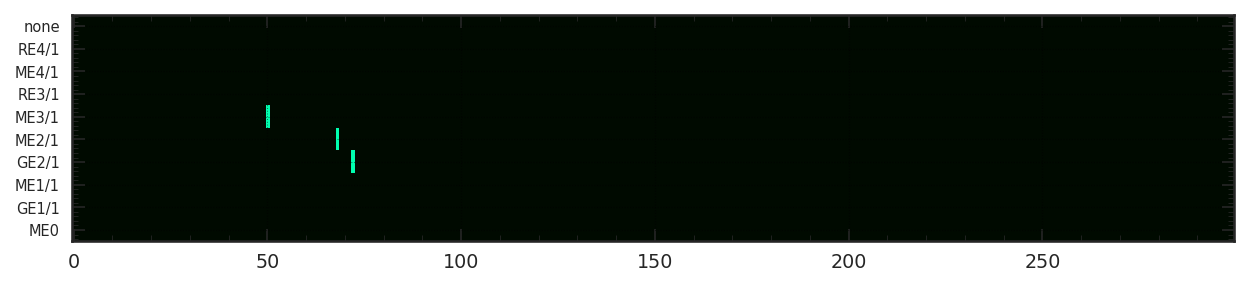

(array([4, 4, 5]), array([64, 68, 50]))
(array([3, 4, 5]), array([72, 68, 50]))


In [16]:
display_image(zone, images[2])
display_image(zone, images_gt[2], cmap=green_hot)

print(np.nonzero(images[2][...,0]))
print(np.nonzero(images_gt[2][...,0]))

### Shapes

In [17]:
# Quick check

pref_cols = []
pref_cols_ch0 = []
pref_cols_ch1 = []
pref_cols_ch2 = []

for img_gt in images_gt[:10000]:
  pref_col = np.argmax(img_gt[pref_row, :][...,0])
  pref_cols.append(pref_col)
  pref_cols_ch0.append(img_gt[pref_row, pref_col, 0])
  pref_cols_ch1.append(img_gt[pref_row, pref_col, 1])
  pref_cols_ch2.append(img_gt[pref_row, pref_col, 2])

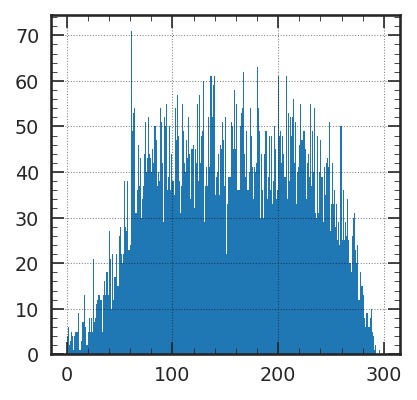

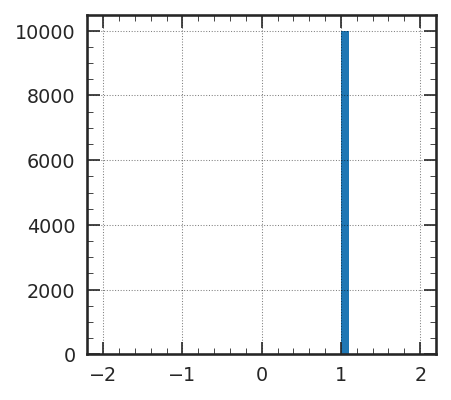

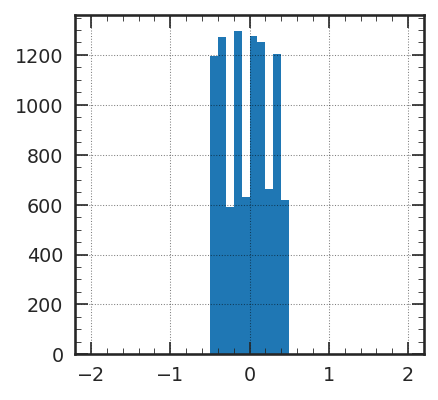

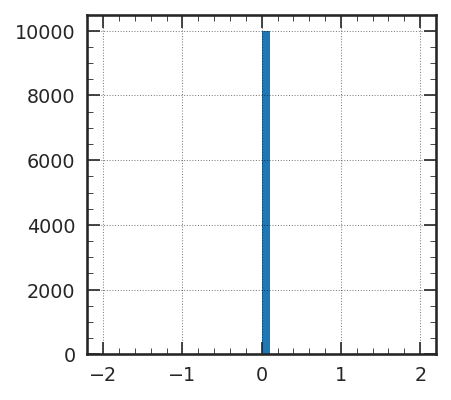

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols, range=(0,num_cols), bins=num_cols)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch0, range=(-2,2), bins=40)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch1, range=(-2,2), bins=40)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch2, range=(-2,2), bins=40)
plt.show()

In [19]:
# Quick check

invpt_vals = []
dzero_vals = []

for par in params:
  (invpt, d0, eta, phi, invpt2) = par
  if np.abs(1.0/invpt2) >= 20.:
    dzero_vals.append(d0)
    dzero_vals.append(-d0)
  if np.abs(d0) <= 20.:
    invpt_vals.append(invpt2)
    invpt_vals.append(-invpt2)

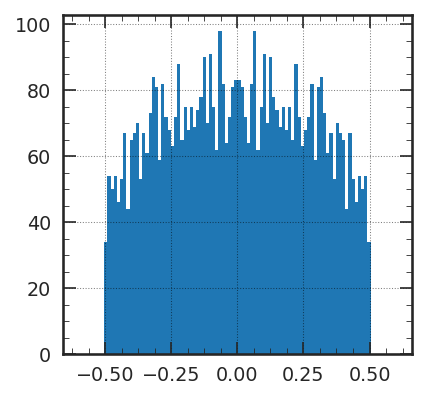

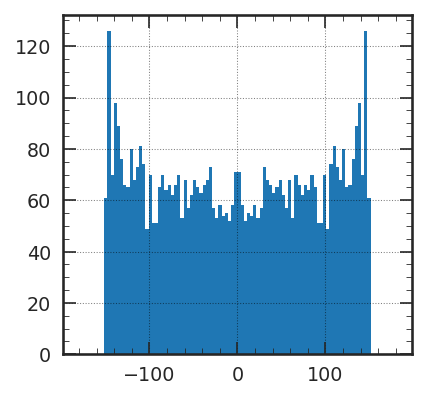

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(invpt_vals, range=(-0.6,0.6), bins=100)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(dzero_vals, range=(-180,180), bins=100)
plt.show()

In [21]:
#print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))
#print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))

print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,22.5,42.5,57.5,77.5,99.5], overwrite_input=True)))
print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,25,44,56,75,99.5], overwrite_input=True)))

invpt binning: [-0.49520983 -0.25192627 -0.06576424  0.06576424  0.25192627  0.49520983]
d0 binning: [-148.8678894   -81.48850632  -21.08108292   21.08108292   81.48850632
  148.8678894 ]


In [22]:
do_shapes = True

shapes_col_offset = 50

shapes_num_cols = 100

shapes_num_par_rows = len(invpt_bins)-1

shapes_num_par_cols = len(dzero_bins)-1

def build_images_shapes():
  shapes_img = np.zeros((shapes_num_par_rows, shapes_num_par_cols, num_rows, shapes_num_cols, 1), dtype=np.float32)
  i = 0

  for img, par in zip(images_gt, params):
    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    pref_col = np.argmax(img[pref_row, :][...,0])
    rows, cols = np.nonzero(img[...,0])

    par_row, par_col = find_par_row_col(par)
    mirror_par_row, mirror_par_col = (shapes_num_par_rows-1)-par_row, (shapes_num_par_cols-1)-par_col

    for row, col in zip(rows, cols):
      col = col - pref_col + shapes_col_offset
      if 0 <= col < shapes_num_cols:
        shapes_img[par_row, par_col, row, col] += 1.0
      # mirror image
      mirror_col = (shapes_num_cols) - col
      if 0 <= mirror_col < shapes_num_cols:
        shapes_img[mirror_par_row, mirror_par_col, row, mirror_col] += 1.0
    i += 1
  return shapes_img

In [23]:
if do_shapes:
  shapes_img = build_images_shapes()
  shapes_img_orig = shapes_img.copy()

Building image 0
Building image 10000


In [24]:
def antialias_image(img):
  # Reference:
  #   https://github.com/adobe/antialiased-cnns
  #   https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/ReflectionPad.cpp

  # Apply padding
  filt_size = 3
  pad_l = 1
  pad_t = 0
  old_shape = img.shape
  new_shape = (old_shape[0] + pad_t * 2, old_shape[1] + pad_l * 2, old_shape[2])
  img_padded = img.copy()
  img_padded.resize(new_shape)
  #print(img.shape, img_padded.shape)

  for i in range(new_shape[0]):
    if i < pad_t:
      ip_y = pad_t * 2 - i
    elif i >= old_shape[0] + pad_t:
      ip_y = (old_shape[0] + pad_t - 1) * 2 - i
    else:
      ip_y = i
    ip_y = ip_y - pad_t

    for j in range(new_shape[1]):
      if j < pad_l:
        ip_x = pad_l * 2 - j
      elif j >= old_shape[1] + pad_l:
        ip_x = (old_shape[1] + pad_l - 1) * 2 - j
      else:
        ip_x = j
      ip_x = ip_x - pad_l

      # Padding
      img_padded[i, j] = img[ip_y, ip_x]
      #print((i,j), (ip_y,ip_x))

  # Apply anti-aliasing
  #filt = np.array([1., 2., 1.])  # 1D
  filt = np.array([1., 4., 1.])  # 1D
  filt = filt / np.sum(filt)
  filt = filt.reshape((1, filt_size, 1))
  img_antialiased = img.copy()

  for i in range(new_shape[0]):
    for j in range(new_shape[1]):
      if i >= pad_t and i < old_shape[0] + pad_t:
        if j >= pad_l and j < old_shape[1] + pad_l:
          ip_y = i - pad_t
          ip_x = j - pad_l
          img_antialiased[ip_y, ip_x] = np.sum(filt * img_padded[i-pad_t:i+pad_t+1, j-pad_l:j+pad_l+1])
          #print((i,j), (ip_y,ip_x), ((i-pad_t,i+pad_t+1),(j-pad_l,j+pad_l+1)))

  # Remove anti-aliasing on pref_row
  img_antialiased[pref_row, :] = img[pref_row, :]
  return img_antialiased

def normalize_image(img):
  norm = np.sqrt(np.square(img).sum(axis=-2, keepdims=True))
  norm[norm == 0] = 1.0
  img /= norm
  img[img < 1e-2] = 0.0
  return img

def display_image_shapes(zone, shapes_img_orig, shapes_img, cmap=blue_hot, figsize=(10,10)):
  fig, axs = plt.subplots(shapes_num_par_rows, shapes_num_par_cols, figsize=figsize, tight_layout=True, sharex=True, sharey=True)
  for i in range(shapes_num_par_rows):
    for j in range(shapes_num_par_cols):
      ax = axs[(shapes_num_par_rows-1)-i, j]  # axs[0,0] is top left
      img_orig = shapes_img_orig[i, j]
      img = img_orig.copy()
      img = antialias_image(img)
      img = normalize_image(img)
      shapes_img[i, j] = img
      print(i, j, img_orig.sum(), img.sum())
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
                cmap=my_cmap)
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  plt.show()

0 0 7269.0 38.663517
0 1 10621.0 39.0036
0 2 10499.0 40.56543
0 3 12905.0 39.332714
0 4 12920.0 37.547226
1 0 11276.0 39.671898
1 1 10834.0 37.681812
1 2 9195.0 38.737404
1 3 11483.0 38.29363
1 4 10929.0 38.9982
2 0 9181.0 35.437054
2 1 7744.0 30.183634
2 2 5684.0 28.127642
2 3 7744.0 30.183634
2 4 9179.0 35.44412
3 0 10964.0 39.17988
3 1 11507.0 38.445736
3 2 9214.0 38.87353
3 3 10844.0 37.744873
3 4 11274.0 39.663235
4 0 13011.0 37.677124
4 1 12955.0 39.557938
4 2 10500.0 40.754627
4 3 10688.0 39.23385
4 4 7286.0 38.84633


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


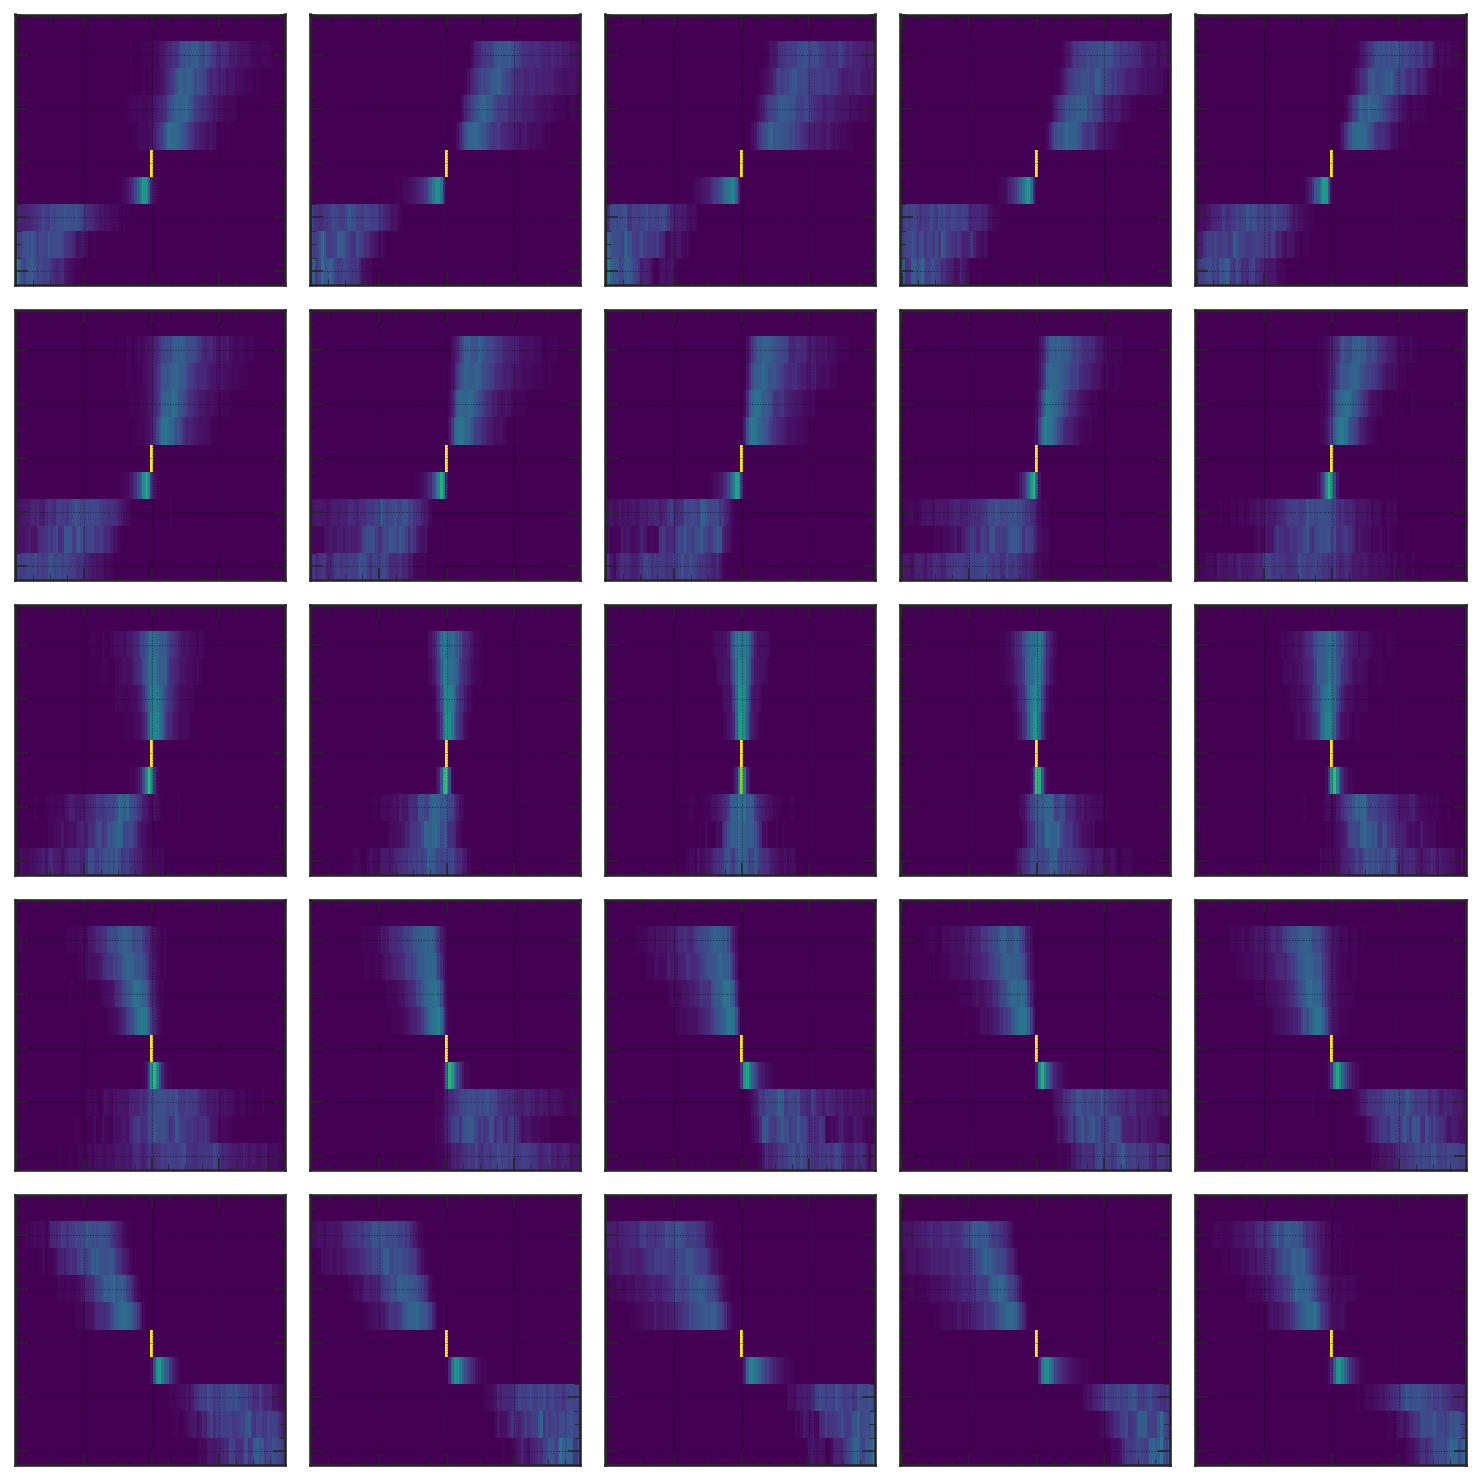

In [25]:
if do_shapes:
  display_image_shapes(zone, shapes_img_orig, shapes_img)

In [26]:
if do_shapes:
  # Write
  outfile = 'shapes_img_zone%i.npz' % zone
  save_np_arrays(outfile, dict(shapes_img=shapes_img))